In [4]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
# Read data
import pickle
features = pickle.load(open("/home/mids-w251-fa2020-fp/feat2.txt", "rb"))
labels = pickle.load(open("/home/mids-w251-fa2020-fp/labels2.txt", "rb"))

In [18]:
X = np.array(features)
Y = np.array(labels)

In [105]:
from numpy import *
import numpy as N
import pylab as P

def estimated_autocorrelation(x):
    '''Given a time series curve, calculate autocorrelation'''
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = N.correlate(x, x, mode = 'full')[-n:]
    #assert N.allclose(r, N.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(N.arange(n, 0, -1)))
    return result

def calc_freq(x):
    '''Given a periodic curve, find the periodicity'''
    time = range(0,len(x))
    x_ac = estimated_autocorrelation(x)
    freq = ((x_ac[:-1] * x_ac[1:]) < 0).sum()/2 /15 * 60
    P.plot(time,x_ac)
    P.xlabel('time (s)')
    P.ylabel('autocorrelation')
    P.show()
    return freq

def find_sample_freq(df, fps = 30):
    '''Given a single sample, with dimension [440, 2, 9], predict frequency for all 2 x 9 keypoints. '''
    
    n_frames = df.shape[0]
    n_dim = df.shape[1]
    n_kps = df.shape[2]
    
    rslt = []
    
    for i in [1]: # fix to only process the y points
        for j in range(n_kps): 
            x = df[:,i,j] 
            rslt += [calc_freq(x)]
    return rslt

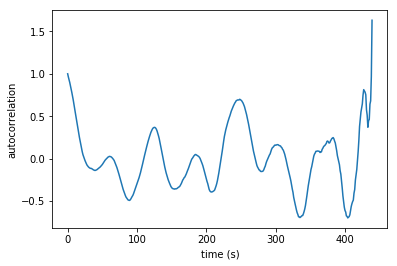

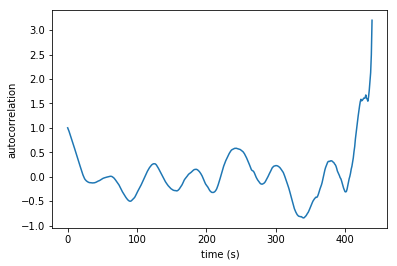

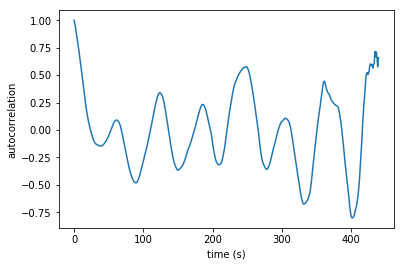

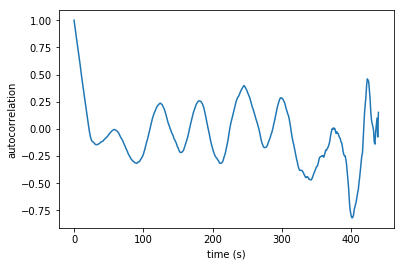

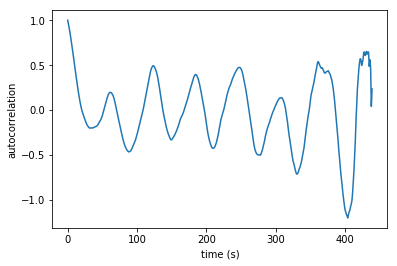

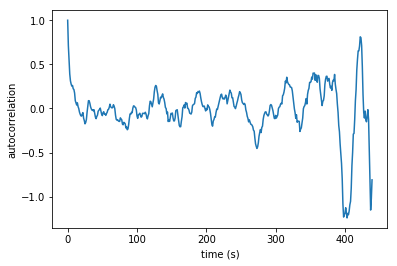

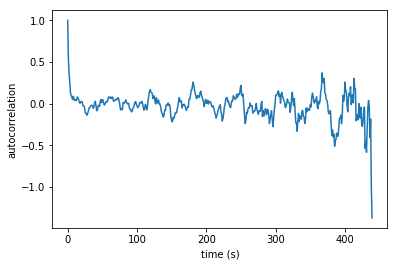

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


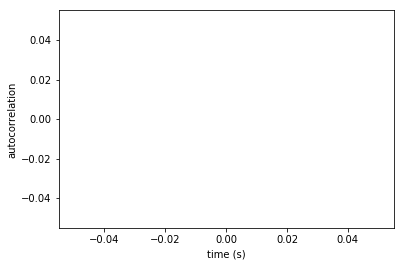

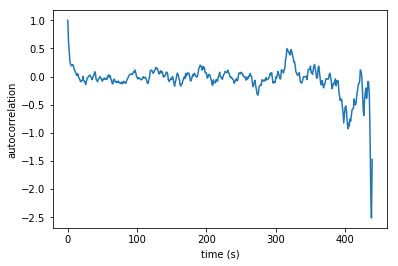

[28.0, 28.0, 28.0, 36.0, 28.0, 58.0, 126.0, 0.0, 110.0]

In [109]:
find_sample_freq(X[1])

In [110]:
Y[1]

29

In [29]:
def process_input_features(X):
    n_sample = len(X)
    kp_pred_freq = [] * n_sample
    for i in range(len(X)):
        kp_pred_freq.append(find_sample_freq(X[i]))
    return kp_pred_freq

### Attempt 1: using heuristics, filter out predicted breathing rate less than 5 or greater than 50, then take the median of the rest

In [111]:
import statistics
def find_opt_br(x):
    '''Given a list 18 possible br, find the median'''
    try: 
        return statistics.mean([r for r in x if r > 5 and r < 50])
    except: 
        return nan
    

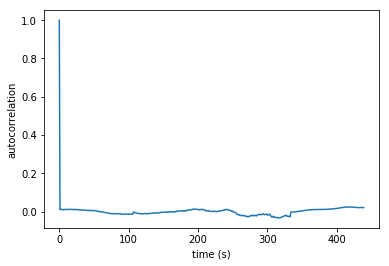

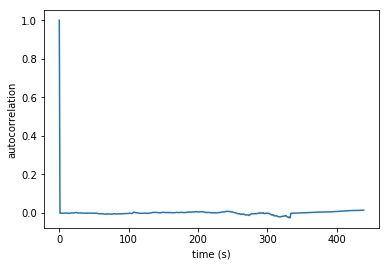

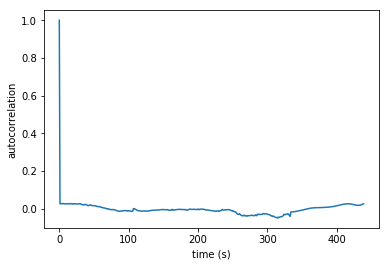

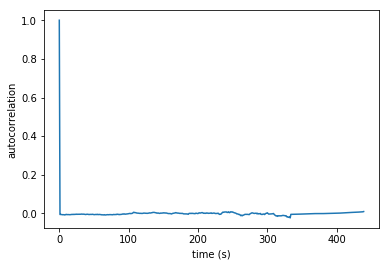

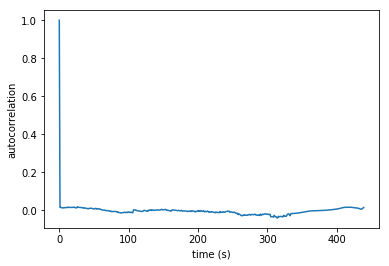

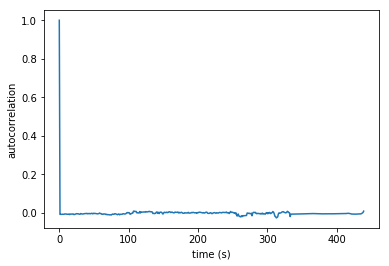

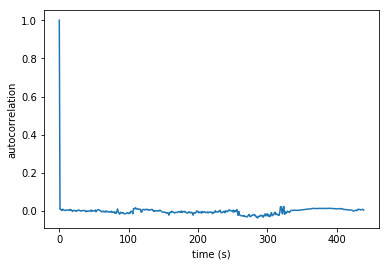

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


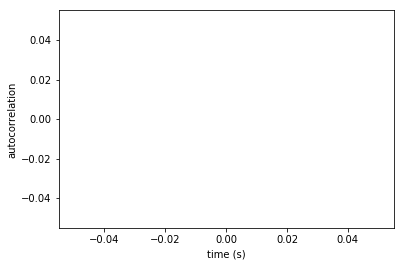

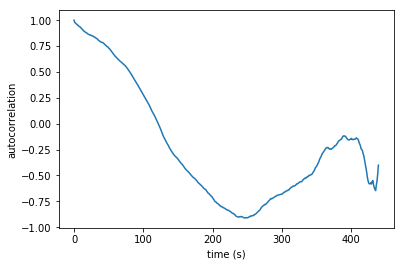

27.0

In [113]:
find_opt_br(find_sample_freq(X[85]))

In [78]:
proc_X = process_input_features(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [79]:
sample_br = []
for i in range(len(proc_X)):
    sample_br.append(find_opt_br(proc_X[i]))

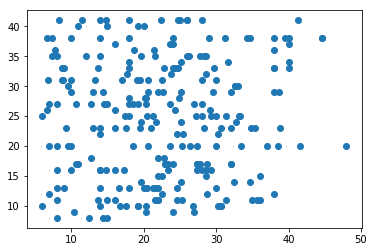

In [80]:
plt.scatter(sample_br, Y)

In [81]:
df = pd.DataFrame(list(zip(sample_br, Y)))
df.dropna()
print("MAE: ", mean(abs(df[0] - df[1])))

MAE:  10.895657142857145


In [102]:
df[df[1]<10]

,0,1
11,8.000000,8
43,14.333333,8
85,27.000000,9
120,24.000000,9
149,12.500000,8
230,15.000000,8
245,20.333333,9
255,10.400000,9


### Attempt 2: trying building a multi-linear regression model

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(proc_X, Y, test_size=0.15, random_state=24601)

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
kfold = model_selection.KFold(n_splits = 10, random_state = 7, shuffle = True)
model = LinearRegression()
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print("MAE: %.3f (%.3f)" % (results.mean(), results.std()))

MAE: -8.443 (1.190)


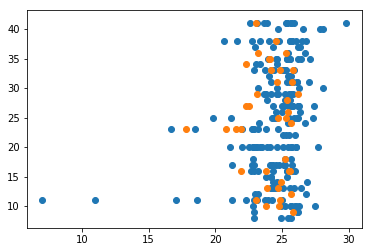

In [61]:
model.fit(X_train, Y_train)
plt.scatter(model.predict(X_train), Y_train)
plt.scatter(model.predict(X_test), Y_test)

### Attempt 3: trying building a decision tree model

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
kfold = model_selection.KFold(n_splits = 10, random_state = 7, shuffle = True)
model = DecisionTreeRegressor()
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
print("MAE: %.3f (%.3f)" % (results.mean(), results.std()))

MAE: -10.605 (1.447)


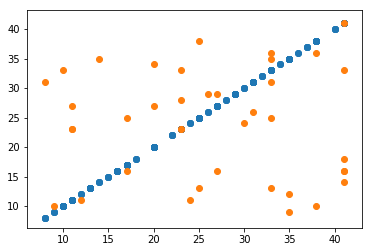

In [63]:
model.fit(X_train, Y_train)
plt.scatter(model.predict(X_train), Y_train)
plt.scatter(model.predict(X_test), Y_test)